<a href="https://colab.research.google.com/github/tibayo1/Leukemia-DL-Diagnosis/blob/master/leukemia_dl_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Details of the Project

**Journal**: [Human-level recognition of blast cells in acute myeloid
leukemia with convolutional neural networks](https://www.biorxiv.org/content/10.1101/564039v1.full.pdf)



**Materials and Methods of Journal**:


*   Peripheral blood smears were selected from 100 patients diagnosed with different subtypes of AML at the Laboratory of Leukemia Diagnostics at Munich University Hospital between 2014 and 2017, and smears from 100 patients found to exhibit no morphological features of hematological malignancies in the same time frame.
*   The resulting digitised data consisted of multiresolution pyramidal images of a size of approximately 1 GB per scanned area of interest.

*   For our image classification task, we used a ResNeXt CNN topology
*   The network was trained for at least 20 epochs, which took a computing time of approximately 4 days on a Nvidia GeForce GTX TITAN X GPU.


*   We adopted the network to input image dimensions of
400 x 400 x 3 and retained the cardinality hyper-parameter at C = 32 
*   We randomly divide the images contained in each class of our dataset in a test- and
training group, where the training group contains approximately 80%, and the test group
20% of the images


*   Random rotational transformations of 0−359 degrees, as well as random horizontal and vertical ﬂips to the single-cell images in the dataset.

*   In the end the data set was augmented in such a way that each class contained approximately 10,000 images for training.




**Datasets**:  [Datasets of Blood smear images for AML(Acute Myleoid Leukemia) Diagnosis](https://www.kaggle.com/lsaa2014/single-cell-morphological-dataset-of-leukocytes)

**Implementtion Procedure** 

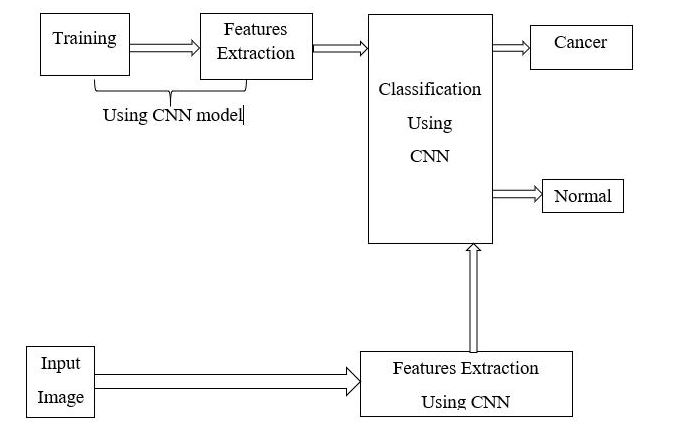

Image source: https://aihubprojects.com/blood-cancer-detection-using-cnn-ai-projects/



In [9]:
#Immport needed Libiraries 
import os
import json
import numpy as np
import torch
from torch import nn
from torchvision import transforms, datasets, models
import math
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision as tv
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import OrderedDict
import torch.optim as optim
%matplotlib inline


In [2]:
#Getting data for Kaggle 
# read file
with open('/content/kaggle.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
#get username and key
kaggle_key = str(obj['key'])
kaggle_username = str(obj['username'])
# parse file
obj = json.loads(data)

os.environ['KAGGLE_USERNAME'] = kaggle_username # username from the json file
os.environ['KAGGLE_KEY'] = kaggle_key # key from the json file
!kaggle datasets download -d lsaa2014/single-cell-morphological-dataset-of-leukocytes

100% 5.74G/5.74G [02:04<00:00, 45.2MB/s]
100% 5.74G/5.74G [02:04<00:00, 49.6MB/s]


In [3]:
!unzip 'single-cell-morphological-dataset-of-leukocytes.zip'

Streaming output truncated to the last 5000 lines.
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3575.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3576.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3577.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3578.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3579.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3580.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3581.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3582.tiff  
  inflating: blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD/NGS/NGS_3583.tiff  
  inflating: blood_smear_images_for_aml_

In [4]:
os.listdir("/content/blood_smear_images_for_aml_diagnosis_MOD")

['Abbreviations.txt', 'annotations.dat', 'AML-Cytomorphology_LMU_MOD']

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
num_workers = 0
batch_size = 100
valid_size = 0.2
test_size = 0.2


#Transforming the Data
train_transform = transforms.Compose([ transforms.Resize(400,400), transforms.RandomRotation(359),
                                        transforms.RandomHorizontalFlip(0.2),
                                        transforms.RandomVerticalFlip(0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])
train_data = datasets.ImageFolder("/content/blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD", transform=train_transform)

# obtain training indices that will be used for testing and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler =  SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
#You can check Abbreviations.txt to understand the Abbrevations 
classes = ['BAS', 'EBO', 'EOS', 'KSC','LYT','MON', 'MYO', 'NGB', 'NGS', 'PMO']





## **Visualize the Data**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

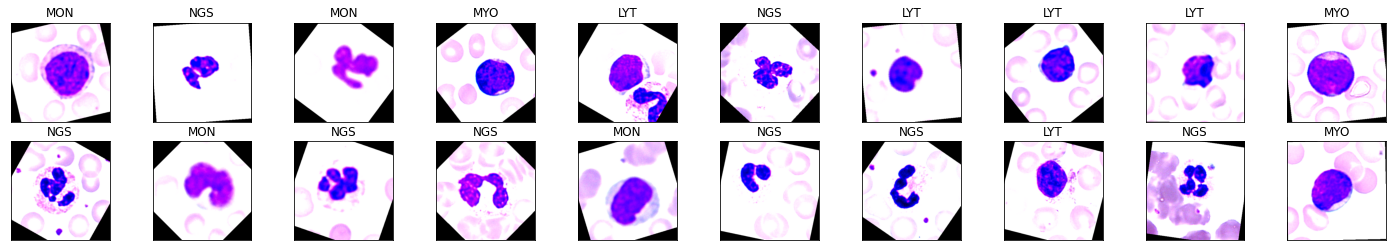

In [7]:
def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Define Model **


In [8]:
model = models.vgg16(pretrained=True)
#freeze the model calssifier
for param in model.features.parameters():
  param.requires_grad = False

#Last layers of the pretrained network replaced with new layers which can classify the input images into 10 
classifier = nn.Sequential(OrderedDict([                            
                          ('fc1', nn.Linear(4096, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 10))]))

model.classifier[6] = classifier
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Specify Loss function and Optimizer**

In [11]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

if train_on_gpu:
    model.cuda()

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Training**

In [ ]:
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
     
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()